# Первая модель 4 декабря 2025

## 1. Импорт библиотек и загрузка данных
Раздел «Imports & Data Loading»:  
Импорты  
Загрузка train 
Быстрый .head()  
Проверка формы датасета  
Краткие описания колонок (комментариями)

### Импорты

In [1]:
import os

import pandas as  pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

### Загрузка train и Быстрый .head()

In [2]:
data_path = '../../Data/Kaggle/titanic/'

files = os.listdir(data_path)
for i in range(len(files)):
    print(f'file {i} - {files[i]}')

file 0 - test.csv
file 1 - train.csv
file 2 - gender_submission.csv


In [3]:
df_train_row = pd.read_csv(f'{data_path}{files[1]}')
df_train_row.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Краткие описания колонок (комментариями)

PassengerId — уникальный идентификатор пассажира, просто индекс.  
Survived — целевая переменная: 0 = погиб, 1 = выжил.  
Pclass — класс обслуживания: 1-й (дорогой), 2-й, 3-й (дешёвый).  
Name — имя (можно извлечь звание/титул: Mr, Miss, Mrs, etc.).  
Sex — пол (ключевой фактор выживания).  
Age — возраст (много пропусков → важна обработка).  
SibSp — количество родственников по боковой линии (братья, сёстры, супруги).  
Parch — количество родителей и детей.  
Ticket — номер билета (можно делать группировки).  
Fare — стоимость билета (важно для богатых → выше шанс выжить).  
Cabin — каюта (почти всё пропущено, но буква палубы полезна).  
Embarked — порт отправления: S, C, Q.  
  
  
Так какбудет использоваться логистическая регресссия, то порядковая переменная будет обрабатываться как номинальная
До заполнения пропусков нужно обработать выбросы

## 2. Анализ данных и обработка признаков

Общие статитики по датасету  
Анализ численных признаков  
Обработка числовых признаков  
Анализ нечисловых признаков  
Обработка нечисловых признаков  
Создание новых признкаов

### Общие статитики по датасету

In [4]:
#Проверка на пропуски

df_train_row.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
# Статистики

display(df_train_row.describe())
display(df_train_row.describe(include=['object']))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,G6,S
freq,1,577,7,4,644


In [6]:
feature_id = 'PassengerId'
target_name = 'Survived'
list_num_ftrs = [	
     'Age'
    ,'SibSp'
    ,'Parch'
    ,'Fare'
]
list_not_num_ftrs = [
     'Pclass'
    ,'Name'
    ,'Sex'
    ,'Ticket'
    ,'Cabin'
    ,'Embarked'

]

if set(df_train_row.columns) == set(list_num_ftrs + list_not_num_ftrs + [feature_id, target_name]):
    print('Все переменные распределены')
else:
    print('Переменные не распределены')

Все переменные распределены


In [7]:
display(df_train_row[list_num_ftrs].info())
display(df_train_row[list_not_num_ftrs].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     714 non-null    float64
 1   SibSp   891 non-null    int64  
 2   Parch   891 non-null    int64  
 3   Fare    891 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 28.0 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Pclass    891 non-null    int64 
 1   Name      891 non-null    object
 2   Sex       891 non-null    object
 3   Ticket    891 non-null    object
 4   Cabin     204 non-null    object
 5   Embarked  889 non-null    object
dtypes: int64(1), object(5)
memory usage: 41.9+ KB


None

### Анализ численных признаков

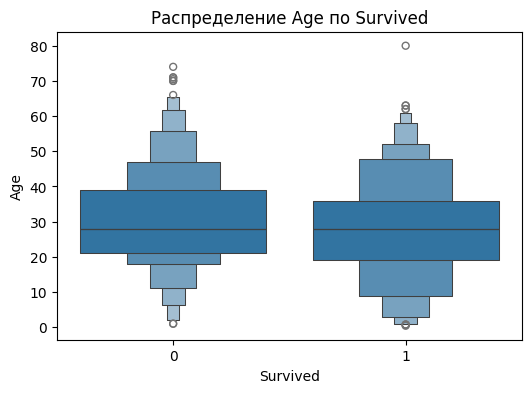

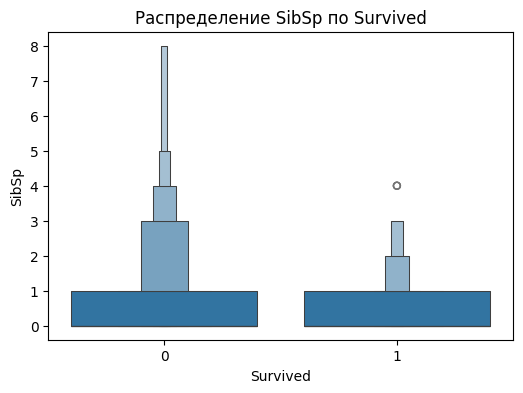

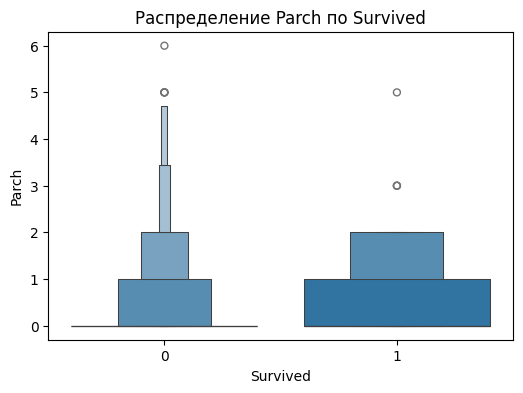

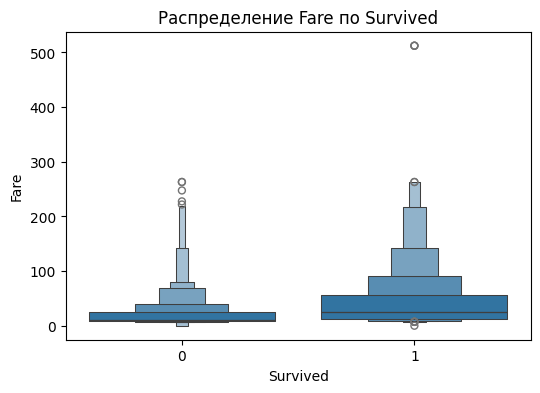

In [8]:
#Аналз распределений

for col in list_num_ftrs:
    plt.figure(figsize=(6, 4), dpi = 100)
    sns.boxenplot(data=df_train_row, x=target_name, y=col)
    plt.title(f"Распределение {col} по {target_name}")
    plt.show()

In [9]:
#Верхние и нижние границы

import numpy as np
for col in list_num_ftrs:
    q1, q3 = df_train_row[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lo = q1 - 1.5 * iqr
    hi = q3 + 1.5 * iqr
    
    print(f"{col} Усы:")
    print("Lower whisker:", lo)
    print("Upper whisker:", hi)


Age Усы:
Lower whisker: -6.6875
Upper whisker: 64.8125
SibSp Усы:
Lower whisker: -1.5
Upper whisker: 2.5
Parch Усы:
Lower whisker: 0.0
Upper whisker: 0.0
Fare Усы:
Lower whisker: -26.724
Upper whisker: 65.6344


#### Обработка ввыбросов

In [10]:

def clip_outliers_iqr(series, col_name, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return series.clip(lower=lower, upper=upper)


In [11]:
# #Обработка выбросов числовых признаков
# df_processed = df_train_row.copy()
# for col in list_num_ftrs:
#     df_processed[col] = clip_outliers_iqr(df_train_row[col])

In [17]:
#Создам отдельный класс, для обработки выбросов в числовых переменных с использованием межквартильного размаха
class ClipOutliersIQR(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, k=1.5):
        self.columns = columns
        self.k = k
        self.bounds_ = {} #Здесь будут сохранятся границы для конкретного столбца

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        for col in self.columns:
            q1 = X[col].quantile(0.25)
            q3 = X[col].quantile(0.75)
            IQR = q3 - q1
            upper = q3 + self.k * IQR
            lower = q1 - self.k * IQR
            self.bounds_[col] = (lower, upper)

        return self

    
    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for col, (lower, upper) in self.bounds_.items():
            X[col] = X[col].clip(lower, upper)

        return X

In [19]:
df_processed = df_train_row.copy()


clip_outlier_num = ClipOutliersIQR(columns=list_num_ftrs)

df_processed = clip_outlier_num.fit_transform(df_train_row)

df_processed

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1.0,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0,PC 17599,65.6344,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0.0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0.0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0.0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0.0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1.0,0,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0.0,0,111369,30.0000,C148,C


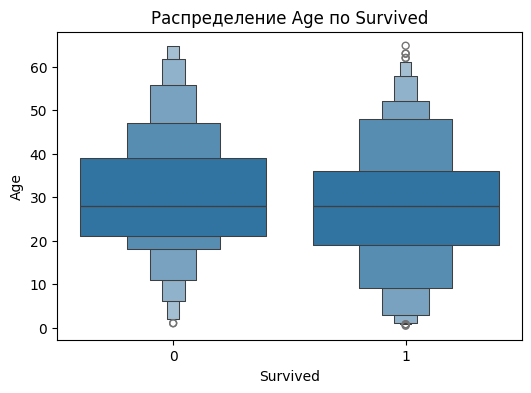

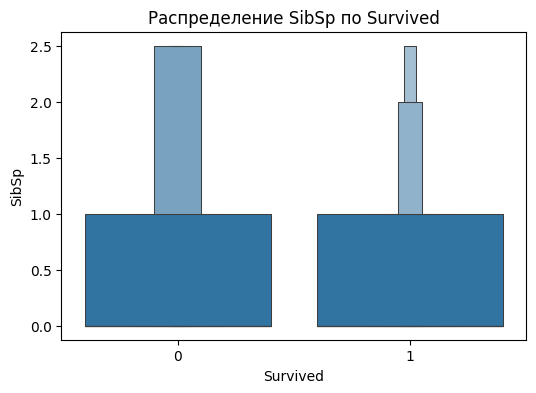

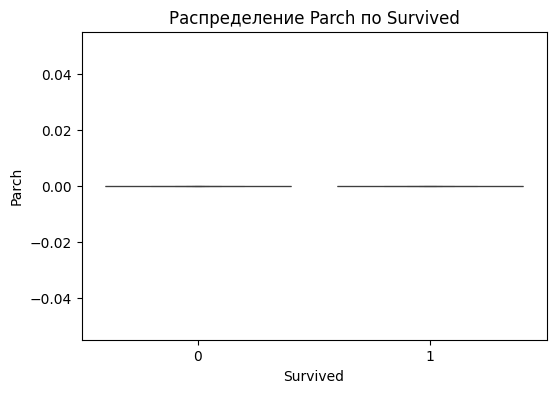

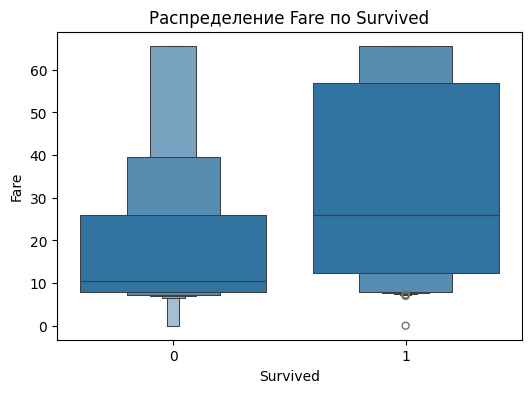

In [12]:
# Распределеиня после выбросов:
#Аналз распределений

for col in list_num_ftrs:
    plt.figure(figsize=(6, 4), dpi = 100)
    sns.boxenplot(data=df_processed, x=target_name, y=col)
    plt.title(f"Распределение {col} по {target_name}")
    plt.show()

<Axes: xlabel='Parch', ylabel='count'>

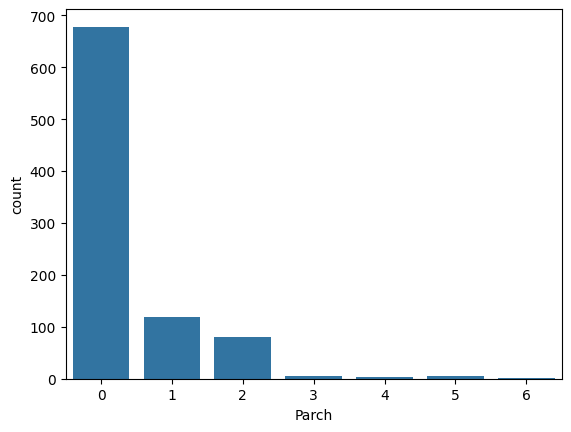

In [13]:
#Слишком разряженный идея заменить на есть или нет

sns.barplot(df_train_row['Parch'].value_counts())

In [14]:
df_processed['Parch'] = df_train_row['Parch'].apply(lambda x: 0 if x==0 else 1)

<Axes: xlabel='Parch', ylabel='count'>

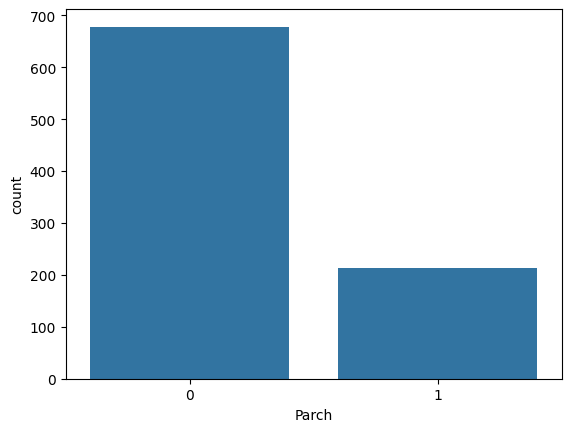

In [15]:
sns.barplot(df_processed['Parch'].value_counts())

In [16]:
df_processed['Parch'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 891 entries, 0 to 890
Series name: Parch
Non-Null Count  Dtype
--------------  -----
891 non-null    int64
dtypes: int64(1)
memory usage: 7.1 KB


In [17]:
df_train_row['Parch'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 891 entries, 0 to 890
Series name: Parch
Non-Null Count  Dtype
--------------  -----
891 non-null    int64
dtypes: int64(1)
memory usage: 7.1 KB


#### Заполнение пропусков
Использую стратегию заполнением медианы согласно классу

In [1]:
for col in list_num_ftrs:
    df_processed[col] = df_processed.groupby(target_name)[col].transform(lambda x: x.fillna(x.median()))

NameError: name 'list_num_ftrs' is not defined

In [19]:
df_processed[list_num_ftrs].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     891 non-null    float64
 1   SibSp   891 non-null    float64
 2   Parch   891 non-null    int64  
 3   Fare    891 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 28.0 KB


In [20]:
df_processed[list_num_ftrs].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     891 non-null    float64
 1   SibSp   891 non-null    float64
 2   Parch   891 non-null    int64  
 3   Fare    891 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 28.0 KB


#### Масштабирование

In [21]:
df_processed[list_num_ftrs].describe()

,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000
mean,29.300345,0.426487,0.239057,24.046813
std,12.830567,0.708246,0.426747,20.481625
min,0.420000,0.000000,0.000000,0.000000
25%,22.000000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,35.000000,1.000000,0.000000,31.000000
max,64.812500,2.500000,1.000000,65.634400


In [22]:
scaller = StandardScaler()
df_processed[list_num_ftrs] = scaller.fit_transform(df_processed[list_num_ftrs])
df_processed[list_num_ftrs].describe()

,Age,SibSp,Parch,Fare
count,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02
mean,2.232906e-16,1.196200e-17,-1.036707e-16,9.968332e-17
std,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00
min,-2.252166e+00,-6.025120e-01,-5.604991e-01,-1.174727e+00
25%,-5.693003e-01,-6.025120e-01,-5.604991e-01,-7.882908e-01
50%,-1.014044e-01,-6.025120e-01,-5.604991e-01,-4.686152e-01
75%,4.444742e-01,8.102200e-01,-5.604991e-01,3.396748e-01
max,2.769332e+00,2.929318e+00,1.784124e+00,2.031623e+00


### Анализ нечисловых признаков

In [23]:
df_processed[list_not_num_ftrs]

,Pclass,Name,Sex,Ticket,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,3,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
4,3,"Allen, Mr. William Henry",male,373450,NaN,S
...,...,...,...,...,...,...
886,2,"Montvila, Rev. Juozas",male,211536,NaN,S
887,1,"Graham, Miss. Margaret Edith",female,112053,B42,S
888,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,W./C. 6607,NaN,S
889,1,"Behr, Mr. Karl Howell",male,111369,C148,C


In [24]:
df_processed[list_not_num_ftrs].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Pclass    891 non-null    int64 
 1   Name      891 non-null    object
 2   Sex       891 non-null    object
 3   Ticket    891 non-null    object
 4   Cabin     204 non-null    object
 5   Embarked  889 non-null    object
dtypes: int64(1), object(5)
memory usage: 41.9+ KB


Так как буду использовать линейную модель, то Pclass это   

#Нужно заполнить пропуски  
Embarked - модой  
Cabin - значением пустоты '9999'

In [25]:
df_processed['Embarked'].fillna(df_processed['Embarked'].mode()[0], inplace=True)
df_processed['Embarked'].value_counts()

Embarked
S    646
C    168
Q     77
Name: count, dtype: int64

In [26]:
for i in set(df_processed['Cabin'].fillna('0').apply(lambda x: x[0])):
    print(i)

C
E
F
D
T
G
0
B
A


In [27]:
df_processed['Cabin'] = df_processed['Cabin'].fillna('0').apply(lambda x: x[0])

In [28]:
df_processed['Cabin'].value_counts()

Cabin
0    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64

In [29]:
df_processed['Embarked'].value_counts().sum()

np.int64(891)

In [30]:
def pref_ticket(string):
    return re.replace(r'\d+','', string)

df_processed['Ticket_prefix'] = df_processed['Ticket'].str.replace(r"\d+",'', regex=True).str.strip()
df_processed['Ticket_prefix'] = df_processed['Ticket_prefix'].replace("", "NONE")
df_processed['Ticket_prefix'] = df_processed['Ticket_prefix'].apply(lambda x: x.lower().replace('.','').split()[0].replace('/','')[:2])

df_processed['Ticket_prefix'].value_counts()

Ticket_prefix
no    661
pc     60
ca     42
a      28
so     27
st     18
sc     17
wc     10
fc      6
c       5
pp      5
li      4
we      3
sw      2
sp      1
fa      1
as      1
Name: count, dtype: int64

In [31]:
sorted(list(df_processed['Ticket_prefix'].apply(lambda x: x.lower().replace('.','').split()[0].replace('/','')[:2]).unique()))

['a',
 'as',
 'c',
 'ca',
 'fa',
 'fc',
 'li',
 'no',
 'pc',
 'pp',
 'sc',
 'so',
 'sp',
 'st',
 'sw',
 'wc',
 'we']

In [32]:
df_processed['Ticket_prefix'].apply(lambda x: x.lower().replace('.','').split()[0].replace('/','')[:2]).value_counts()
df_processed['Ticket_len'] = df_processed['Ticket'].apply(lambda x: len(x))

In [33]:
df_processed['Name'].apply(lambda x: [part for part in x.replace('.', '').strip().split() if len(part)>0]).explode().value_counts()

Name
Mr         517
Miss       182
Mrs        125
William     62
John        44
          ... 
Markun,      1
Johann       1
Najib,       1
Adele        1
Kiamie       1
Name: count, Length: 1672, dtype: int64

In [34]:
df_processed

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_prefix,Ticket_len
0,1,0,3,"Braund, Mr. Owen Harris",male,-0.569300,0.810220,-0.560499,A/5 21171,-0.820552,0,S,a,9
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,0.678422,0.810220,-0.560499,PC 17599,2.031623,C,C,pc,8
2,3,1,3,"Heikkinen, Miss. Laina",female,-0.257370,-0.602512,-0.560499,STON/O2. 3101282,-0.787578,0,S,st,16
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,0.444474,0.810220,-0.560499,113803,1.419297,C,S,no,6
4,5,0,3,"Allen, Mr. William Henry",male,0.444474,-0.602512,-0.560499,373450,-0.781471,0,S,no,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,-0.179387,-0.602512,-0.560499,211536,-0.539655,0,S,no,6
887,888,1,1,"Graham, Miss. Margaret Edith",female,-0.803248,-0.602512,-0.560499,112053,0.290823,B,S,no,6
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,-0.101404,0.810220,1.784124,W./C. 6607,-0.029155,0,S,wc,10
889,890,1,1,"Behr, Mr. Karl Howell",male,-0.257370,-0.602512,-0.560499,111369,0.290823,C,C,no,6


In [35]:
# Идея оставляем только префиксы пола и статуса замужества
def prefix_name(full_name):
    full_name = str(full_name)
    list_names = [part for part in full_name.replace('.', '').strip().lower().split()]
    if 'mr' in list_names:
        return 'mr'
    elif 'miss' in list_names:
        return 'miss'
    elif 'mrs' in list_names:
        return 'mrs'
    else:
        return 'other'

df_processed['Name'] = df_processed['Name'].apply(prefix_name)

df_processed
        

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_prefix,Ticket_len
0,1,0,3,mr,male,-0.569300,0.810220,-0.560499,A/5 21171,-0.820552,0,S,a,9
1,2,1,1,mrs,female,0.678422,0.810220,-0.560499,PC 17599,2.031623,C,C,pc,8
2,3,1,3,miss,female,-0.257370,-0.602512,-0.560499,STON/O2. 3101282,-0.787578,0,S,st,16
3,4,1,1,mrs,female,0.444474,0.810220,-0.560499,113803,1.419297,C,S,no,6
4,5,0,3,mr,male,0.444474,-0.602512,-0.560499,373450,-0.781471,0,S,no,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,other,male,-0.179387,-0.602512,-0.560499,211536,-0.539655,0,S,no,6
887,888,1,1,miss,female,-0.803248,-0.602512,-0.560499,112053,0.290823,B,S,no,6
888,889,0,3,miss,female,-0.101404,0.810220,1.784124,W./C. 6607,-0.029155,0,S,wc,10
889,890,1,1,mr,male,-0.257370,-0.602512,-0.560499,111369,0.290823,C,C,no,6


In [36]:
list_not_num_ftrs

['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

In [37]:
list_not_num_ftrs_updated = ['Pclass', 'Name', 'Sex', 'Ticket_prefix', 'Ticket_len', 'Cabin', 'Embarked']

In [38]:
for col in list_not_num_ftrs_updated:
    display(pd.get_dummies(df_processed[col], prefix=f'{col}_', drop_first=True))

,Pclass__2,Pclass__3
0,False,True
1,False,False
2,False,True
3,False,False
4,False,True
...,...,...
886,True,False
887,False,False
888,False,True
889,False,False


,Name__mr,Name__mrs,Name__other
0,True,False,False
1,False,True,False
2,False,False,False
3,False,True,False
4,True,False,False
...,...,...,...
886,False,False,True
887,False,False,False
888,False,False,False
889,True,False,False


,Sex__male
0,True
1,False
2,False
3,False
4,True
...,...
886,True
887,False
888,False
889,True


,Ticket_prefix__as,Ticket_prefix__c,Ticket_prefix__ca,Ticket_prefix__fa,Ticket_prefix__fc,Ticket_prefix__li,Ticket_prefix__no,Ticket_prefix__pc,Ticket_prefix__pp,Ticket_prefix__sc,Ticket_prefix__so,Ticket_prefix__sp,Ticket_prefix__st,Ticket_prefix__sw,Ticket_prefix__wc,Ticket_prefix__we
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
3,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
887,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
888,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
889,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False


,Ticket_len__4,Ticket_len__5,Ticket_len__6,Ticket_len__7,Ticket_len__8,Ticket_len__9,Ticket_len__10,Ticket_len__11,Ticket_len__12,Ticket_len__13,Ticket_len__15,Ticket_len__16,Ticket_len__17,Ticket_len__18
0,False,False,False,False,False,True,False,False,False,False,False,False,False,False
1,False,False,False,False,True,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,True,False,False
3,False,False,True,False,False,False,False,False,False,False,False,False,False,False
4,False,False,True,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,False,False,True,False,False,False,False,False,False,False,False,False,False,False
887,False,False,True,False,False,False,False,False,False,False,False,False,False,False
888,False,False,False,False,False,False,True,False,False,False,False,False,False,False
889,False,False,True,False,False,False,False,False,False,False,False,False,False,False


,Cabin__A,Cabin__B,Cabin__C,Cabin__D,Cabin__E,Cabin__F,Cabin__G,Cabin__T
0,False,False,False,False,False,False,False,False
1,False,False,True,False,False,False,False,False
2,False,False,False,False,False,False,False,False
3,False,False,True,False,False,False,False,False
4,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
886,False,False,False,False,False,False,False,False
887,False,True,False,False,False,False,False,False
888,False,False,False,False,False,False,False,False
889,False,False,True,False,False,False,False,False


,Embarked__Q,Embarked__S
0,False,True
1,False,False
2,False,True
3,False,True
4,False,True
...,...,...
886,False,True
887,False,True
888,False,True
889,False,False


### Создание полного датасета для препроцессинга и обработчик новых данных

In [39]:
df_full_processed = df_processed[[feature_id, target_name] + list_num_ftrs]
df_full_processed

,PassengerId,Survived,Age,SibSp,Parch,Fare
0,1,0,-0.569300,0.810220,-0.560499,-0.820552
1,2,1,0.678422,0.810220,-0.560499,2.031623
2,3,1,-0.257370,-0.602512,-0.560499,-0.787578
3,4,1,0.444474,0.810220,-0.560499,1.419297
4,5,0,0.444474,-0.602512,-0.560499,-0.781471
...,...,...,...,...,...,...
886,887,0,-0.179387,-0.602512,-0.560499,-0.539655
887,888,1,-0.803248,-0.602512,-0.560499,0.290823
888,889,0,-0.101404,0.810220,1.784124,-0.029155
889,890,1,-0.257370,-0.602512,-0.560499,0.290823


In [40]:
for col in list_not_num_ftrs_updated:
    df_full_processed = pd.concat([df_full_processed, pd.get_dummies(df_processed[col], prefix=f'{col}', drop_first=True)], axis=1)
df_full_processed

,PassengerId,Survived,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Name_mr,Name_mrs,...,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_Q,Embarked_S
0,1,0,-0.569300,0.810220,-0.560499,-0.820552,False,True,True,False,...,False,False,False,False,False,False,False,False,False,True
1,2,1,0.678422,0.810220,-0.560499,2.031623,False,False,False,True,...,False,False,True,False,False,False,False,False,False,False
2,3,1,-0.257370,-0.602512,-0.560499,-0.787578,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
3,4,1,0.444474,0.810220,-0.560499,1.419297,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
4,5,0,0.444474,-0.602512,-0.560499,-0.781471,False,True,True,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,-0.179387,-0.602512,-0.560499,-0.539655,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
887,888,1,-0.803248,-0.602512,-0.560499,0.290823,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
888,889,0,-0.101404,0.810220,1.784124,-0.029155,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
889,890,1,-0.257370,-0.602512,-0.560499,0.290823,False,False,True,False,...,False,False,True,False,False,False,False,False,False,False


['PassengerId', 'Survived', 'Age', 'SibSp', 'Parch', 'Fare']